# I/O Timing Time-Series Analysis (Per-Node)

This notebook visualizes actual disk I/O timing (read_fixed_direct / write_fixed_direct) over time.

## Data Source
- `io_timing_raw.csv`: Raw per-I/O operation data
- `io_timing_aggregated.csv`: Aggregated by time interval, node, and operation

## Key Metrics
- **elapsed_us**: Actual disk I/O latency in microseconds
- **bandwidth_mib_s**: Per-operation bandwidth in MiB/s
- **op**: Operation type (READ or WRITE)

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns
from datetime import datetime

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Configure plot sizes
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['font.size'] = 12

In [8]:
# Load the raw CSV
RESULTS_DIR = Path('/work/NBB/rmaeda/workspace/rust/benchfs/results/benchfs/2026.01.23-14.36.23-debug_large/2026.01.23-14.42.23-540469.nqsv-16')

csv_path = RESULTS_DIR / 'io_timing_raw.csv'
if not csv_path.exists():
    print(f"CSV not found at {csv_path}")
    print("Please run extract_io_timing_csv.sh first:")
    print(f"  ./jobs/benchfs/extract_io_timing_csv.sh {RESULTS_DIR} --aggregate 1")
else:
    df = pd.read_csv(csv_path)
    print(f"Loaded {len(df)} records")
    print(f"Columns: {list(df.columns)}")
    df.head()

Loaded 3056408 records
Columns: ['timestamp', 'node', 'op', 'bytes', 'elapsed_us', 'fd', 'offset', 'bandwidth_mib_s']


In [9]:
# Parse timestamps and add relative time
def parse_timestamp(ts_str):
    try:
        ts_str = ts_str.replace('Z', '+00:00')
        return datetime.fromisoformat(ts_str)
    except:
        return None

df['datetime'] = df['timestamp'].apply(parse_timestamp)
df = df.dropna(subset=['datetime'])

start_time = df['datetime'].min()
df['time_relative'] = (df['datetime'] - start_time).dt.total_seconds()

# Convert elapsed_us to ms
df['elapsed_ms'] = df['elapsed_us'] / 1000

# Clean up node names (extract 'bnodeXXX' from potentially corrupted strings)
import re
node_pattern = re.compile(r'(bnode\d+)')
def clean_node_name(node_str):
    match = node_pattern.search(str(node_str))
    return match.group(1) if match else node_str
df['node'] = df['node'].apply(clean_node_name)

# Add time bucket column for later aggregation
time_bucket_interval = 1  # seconds
df['time_bucket'] = (df['time_relative'] // time_bucket_interval).astype(int) * time_bucket_interval

# Basic statistics
print(f"Time range: {df['datetime'].min()} - {df['datetime'].max()}")
print(f"Duration: {df['time_relative'].max():.1f} seconds")
print(f"Operations: {df['op'].unique()}")
print(f"Nodes: {sorted(df['node'].unique())}")
print(f"\nCounts by operation:")
print(df['op'].value_counts())

Time range: 2026-01-23 05:45:05.234069+00:00 - 2026-01-23 05:49:23.001323+00:00
Duration: 257.8 seconds
Operations: ['WRITE' 'READ']
Nodes: ['bnode0', 'bnode029', 'bnode03', 'bnode031', 'bnode034', 'bnode036', 'bnode038', 'bnode039', 'bnode058', 'bnode06', 'bnode062', 'bnode08', 'bnode080', 'bnode081', 'bnode082', 'bnode092', 'bnode094', 'bnode100', 'bnode109', 'bnode12', 'bnode126']

Counts by operation:
op
WRITE    2762034
READ      294373
Name: count, dtype: int64


## 1. Overall Bandwidth Distribution

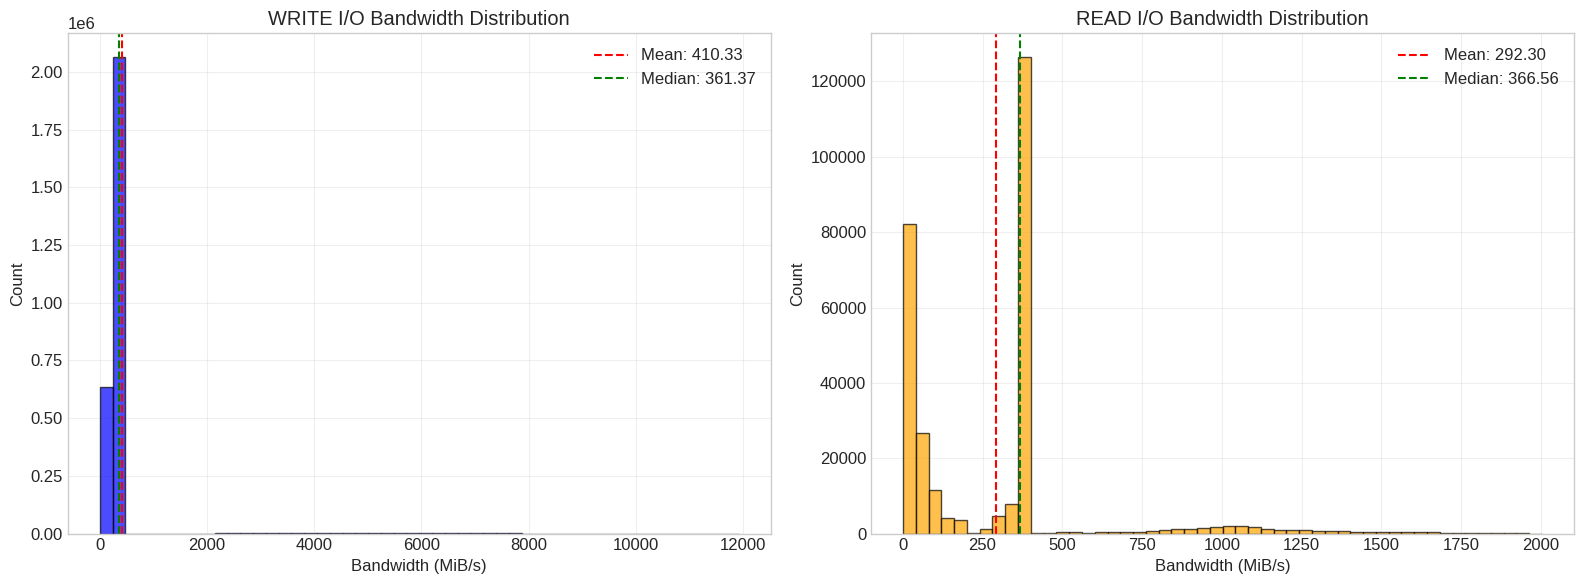


WRITE: count=2,762,034, mean_bw=410.33 MiB/s
READ:  count=294,373, mean_bw=292.30 MiB/s


In [10]:
df_write = df[df['op'] == 'WRITE']
df_read = df[df['op'] == 'READ']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# WRITE bandwidth distribution
ax = axes[0]
if len(df_write) > 0:
    ax.hist(df_write['bandwidth_mib_s'], bins=50, alpha=0.7, color='blue', edgecolor='black')
    ax.axvline(df_write['bandwidth_mib_s'].mean(), color='red', linestyle='--', label=f"Mean: {df_write['bandwidth_mib_s'].mean():.2f}")
    ax.axvline(df_write['bandwidth_mib_s'].median(), color='green', linestyle='--', label=f"Median: {df_write['bandwidth_mib_s'].median():.2f}")
ax.set_xlabel('Bandwidth (MiB/s)')
ax.set_ylabel('Count')
ax.set_title('WRITE I/O Bandwidth Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# READ bandwidth distribution
ax = axes[1]
if len(df_read) > 0:
    ax.hist(df_read['bandwidth_mib_s'], bins=50, alpha=0.7, color='orange', edgecolor='black')
    ax.axvline(df_read['bandwidth_mib_s'].mean(), color='red', linestyle='--', label=f"Mean: {df_read['bandwidth_mib_s'].mean():.2f}")
    ax.axvline(df_read['bandwidth_mib_s'].median(), color='green', linestyle='--', label=f"Median: {df_read['bandwidth_mib_s'].median():.2f}")
ax.set_xlabel('Bandwidth (MiB/s)')
ax.set_ylabel('Count')
ax.set_title('READ I/O Bandwidth Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'io_timing_bandwidth_distribution.png', dpi=150)
plt.show()

print(f"\nWRITE: count={len(df_write):,}, mean_bw={df_write['bandwidth_mib_s'].mean():.2f} MiB/s")
print(f"READ:  count={len(df_read):,}, mean_bw={df_read['bandwidth_mib_s'].mean():.2f} MiB/s")

## 2. Bandwidth Over Time (All Nodes Combined)

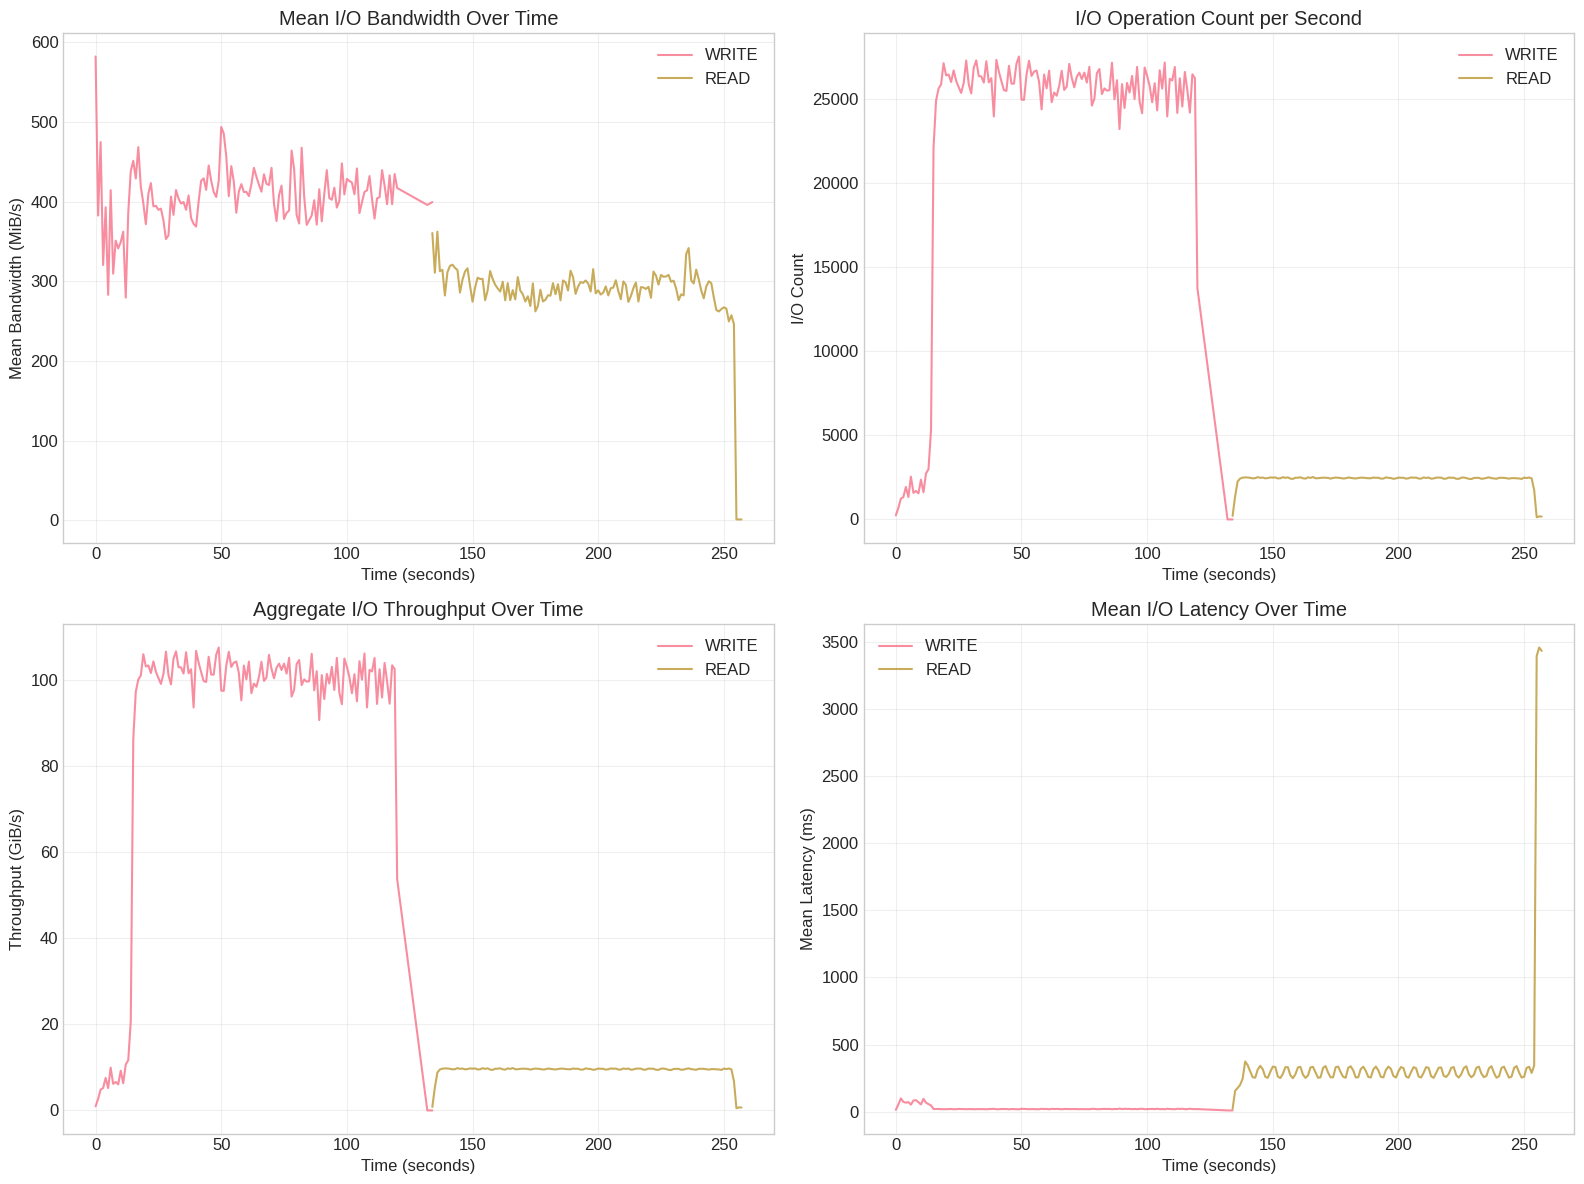

In [11]:
# time_bucket column already added in cell 3

# Calculate statistics per time bucket and operation
time_stats = df.groupby(['time_bucket', 'op']).agg({
    'bandwidth_mib_s': ['mean', 'median', 'min', 'max', 'count'],
    'elapsed_ms': ['mean', 'median'],
    'bytes': 'sum'
}).reset_index()
time_stats.columns = ['time', 'op', 'bw_mean', 'bw_median', 'bw_min', 'bw_max', 'io_count', 'latency_mean', 'latency_median', 'total_bytes']
time_stats['throughput_gib_s'] = time_stats['total_bytes'] / (1024**3) / time_bucket_interval

write_stats = time_stats[time_stats['op'] == 'WRITE']
read_stats = time_stats[time_stats['op'] == 'READ']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Mean bandwidth over time
ax = axes[0, 0]
if len(write_stats) > 0:
    ax.plot(write_stats['time'], write_stats['bw_mean'], label='WRITE', linewidth=1.5, alpha=0.8)
if len(read_stats) > 0:
    ax.plot(read_stats['time'], read_stats['bw_mean'], label='READ', linewidth=1.5, alpha=0.8)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Mean Bandwidth (MiB/s)')
ax.set_title('Mean I/O Bandwidth Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

# I/O count over time
ax = axes[0, 1]
if len(write_stats) > 0:
    ax.plot(write_stats['time'], write_stats['io_count'], label='WRITE', linewidth=1.5, alpha=0.8)
if len(read_stats) > 0:
    ax.plot(read_stats['time'], read_stats['io_count'], label='READ', linewidth=1.5, alpha=0.8)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('I/O Count')
ax.set_title('I/O Operation Count per Second')
ax.legend()
ax.grid(True, alpha=0.3)

# Aggregate throughput over time
ax = axes[1, 0]
if len(write_stats) > 0:
    ax.plot(write_stats['time'], write_stats['throughput_gib_s'], label='WRITE', linewidth=1.5, alpha=0.8)
if len(read_stats) > 0:
    ax.plot(read_stats['time'], read_stats['throughput_gib_s'], label='READ', linewidth=1.5, alpha=0.8)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Throughput (GiB/s)')
ax.set_title('Aggregate I/O Throughput Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

# Mean latency over time
ax = axes[1, 1]
if len(write_stats) > 0:
    ax.plot(write_stats['time'], write_stats['latency_mean'], label='WRITE', linewidth=1.5, alpha=0.8)
if len(read_stats) > 0:
    ax.plot(read_stats['time'], read_stats['latency_mean'], label='READ', linewidth=1.5, alpha=0.8)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Mean Latency (ms)')
ax.set_title('Mean I/O Latency Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'io_timing_over_time.png', dpi=150)
plt.show()

## 3. Per-Node Bandwidth Over Time (WRITE)

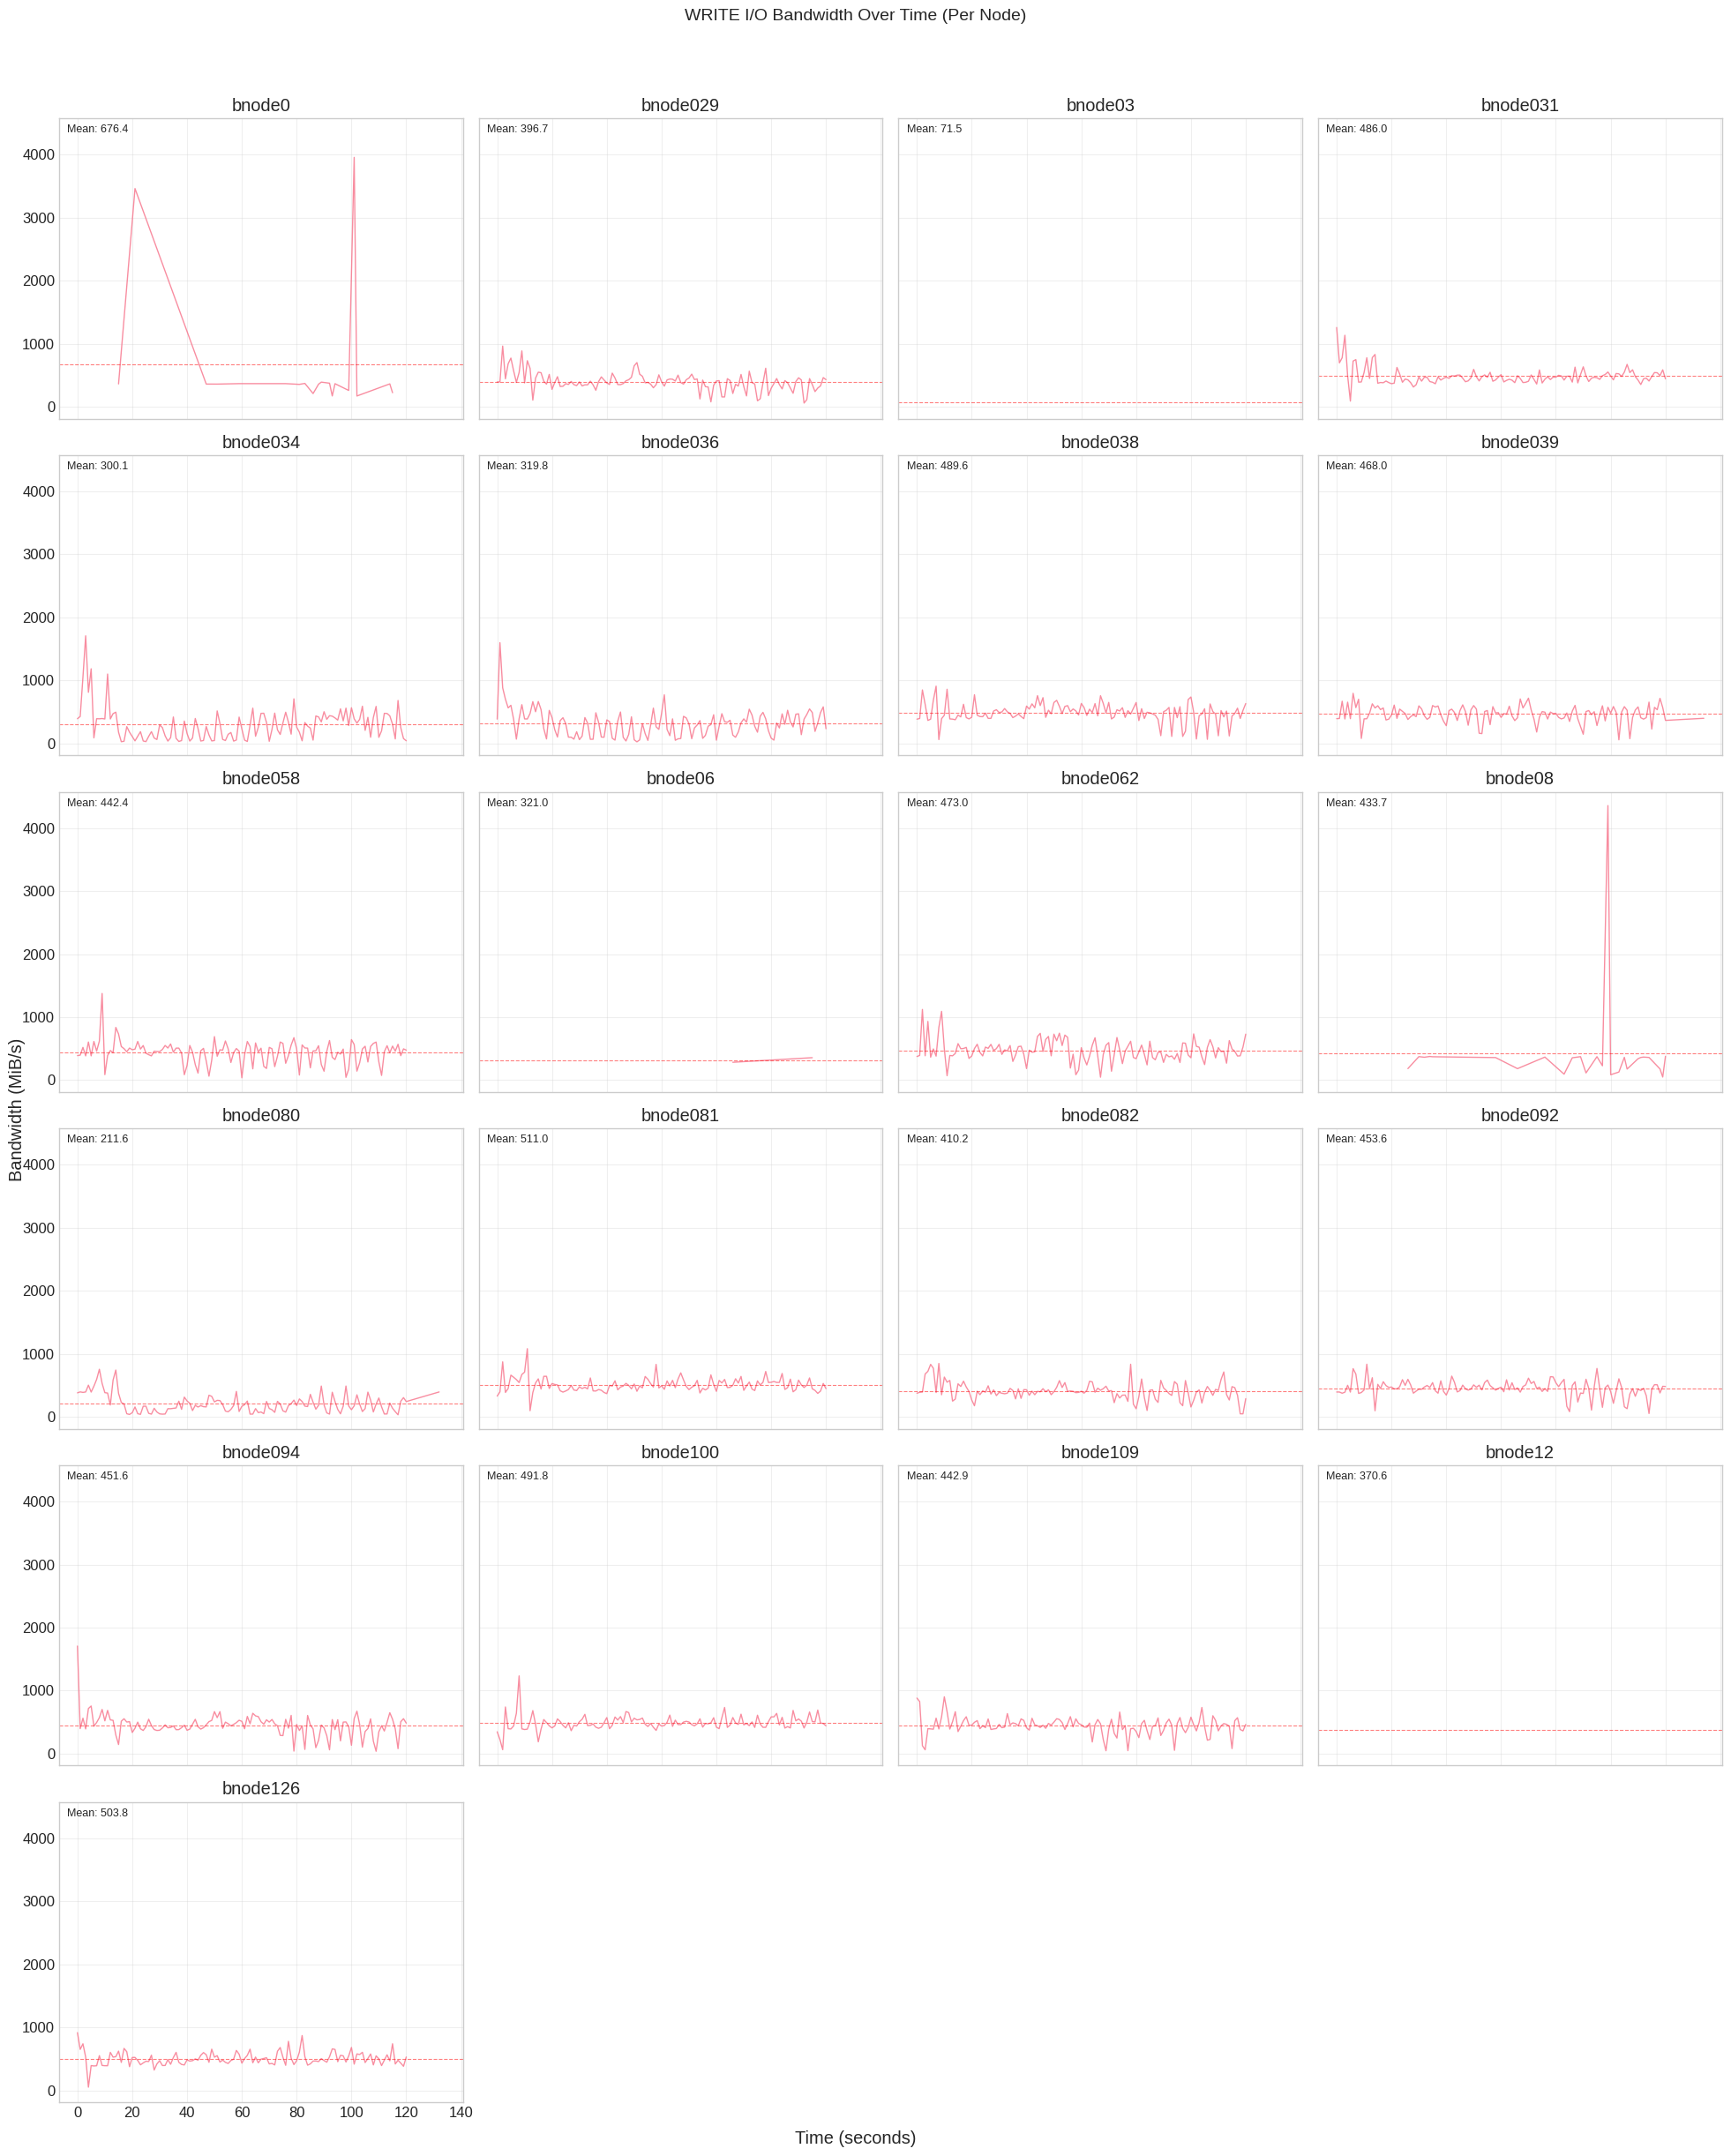

In [12]:
# Per-node statistics over time
def plot_per_node_bandwidth(data, op_name, filename):
    if len(data) == 0:
        print(f"No {op_name} data")
        return
    
    # Aggregate by time bucket and node
    node_time_stats = data.groupby(['time_bucket', 'node']).agg({
        'bandwidth_mib_s': 'mean',
        'bytes': 'sum'
    }).reset_index()
    node_time_stats['throughput_gib_s'] = node_time_stats['bytes'] / (1024**3)
    
    nodes = sorted(data['node'].unique())
    n_nodes = len(nodes)
    
    # Calculate grid size
    n_cols = 4
    n_rows = (n_nodes + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for i, node in enumerate(nodes):
        ax = axes[i]
        node_data = node_time_stats[node_time_stats['node'] == node]
        
        ax.plot(node_data['time_bucket'], node_data['bandwidth_mib_s'], linewidth=1, alpha=0.8)
        ax.set_title(f'{node}')
        ax.grid(True, alpha=0.3)
        
        # Add mean line
        mean_bw = node_data['bandwidth_mib_s'].mean()
        ax.axhline(y=mean_bw, color='red', linestyle='--', alpha=0.5, linewidth=0.8)
        ax.text(0.02, 0.98, f'Mean: {mean_bw:.1f}', transform=ax.transAxes, fontsize=9, va='top')
    
    # Hide unused subplots
    for i in range(n_nodes, len(axes)):
        axes[i].set_visible(False)
    
    fig.suptitle(f'{op_name} I/O Bandwidth Over Time (Per Node)', fontsize=14, y=1.02)
    fig.supxlabel('Time (seconds)')
    fig.supylabel('Bandwidth (MiB/s)')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / filename, dpi=150, bbox_inches='tight')
    plt.show()

plot_per_node_bandwidth(df_write, 'WRITE', 'io_timing_write_per_node.png')

## 4. Per-Node Bandwidth Over Time (READ)

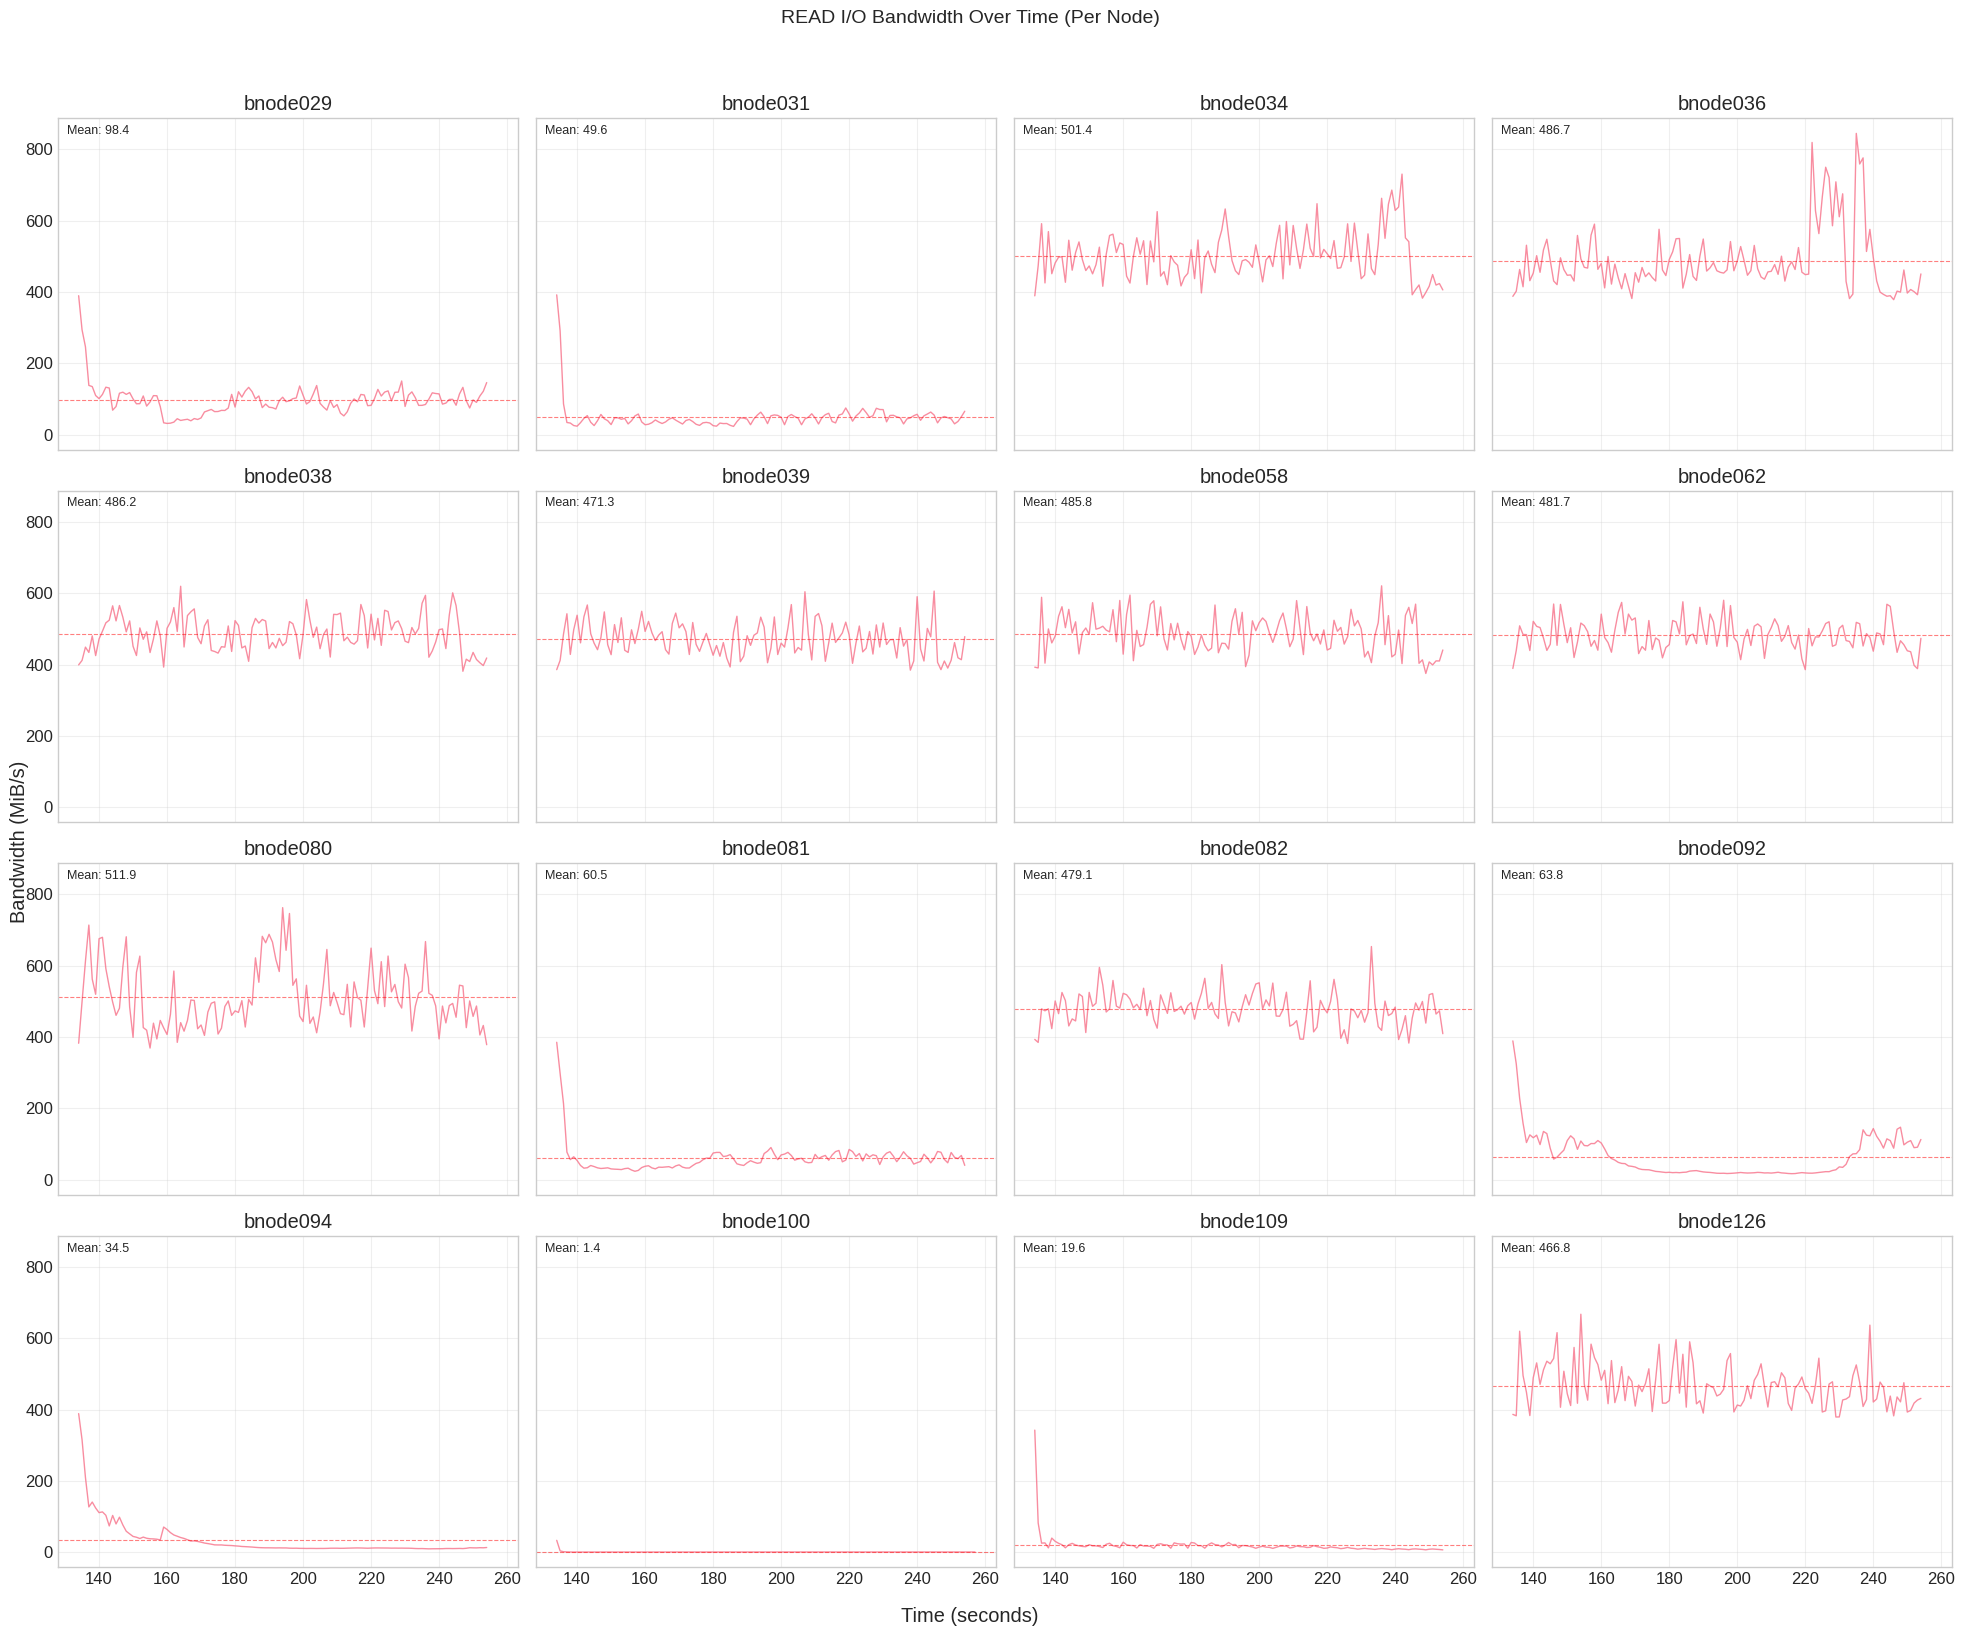

In [13]:
plot_per_node_bandwidth(df_read, 'READ', 'io_timing_read_per_node.png')

## 5. Per-Node Throughput Over Time

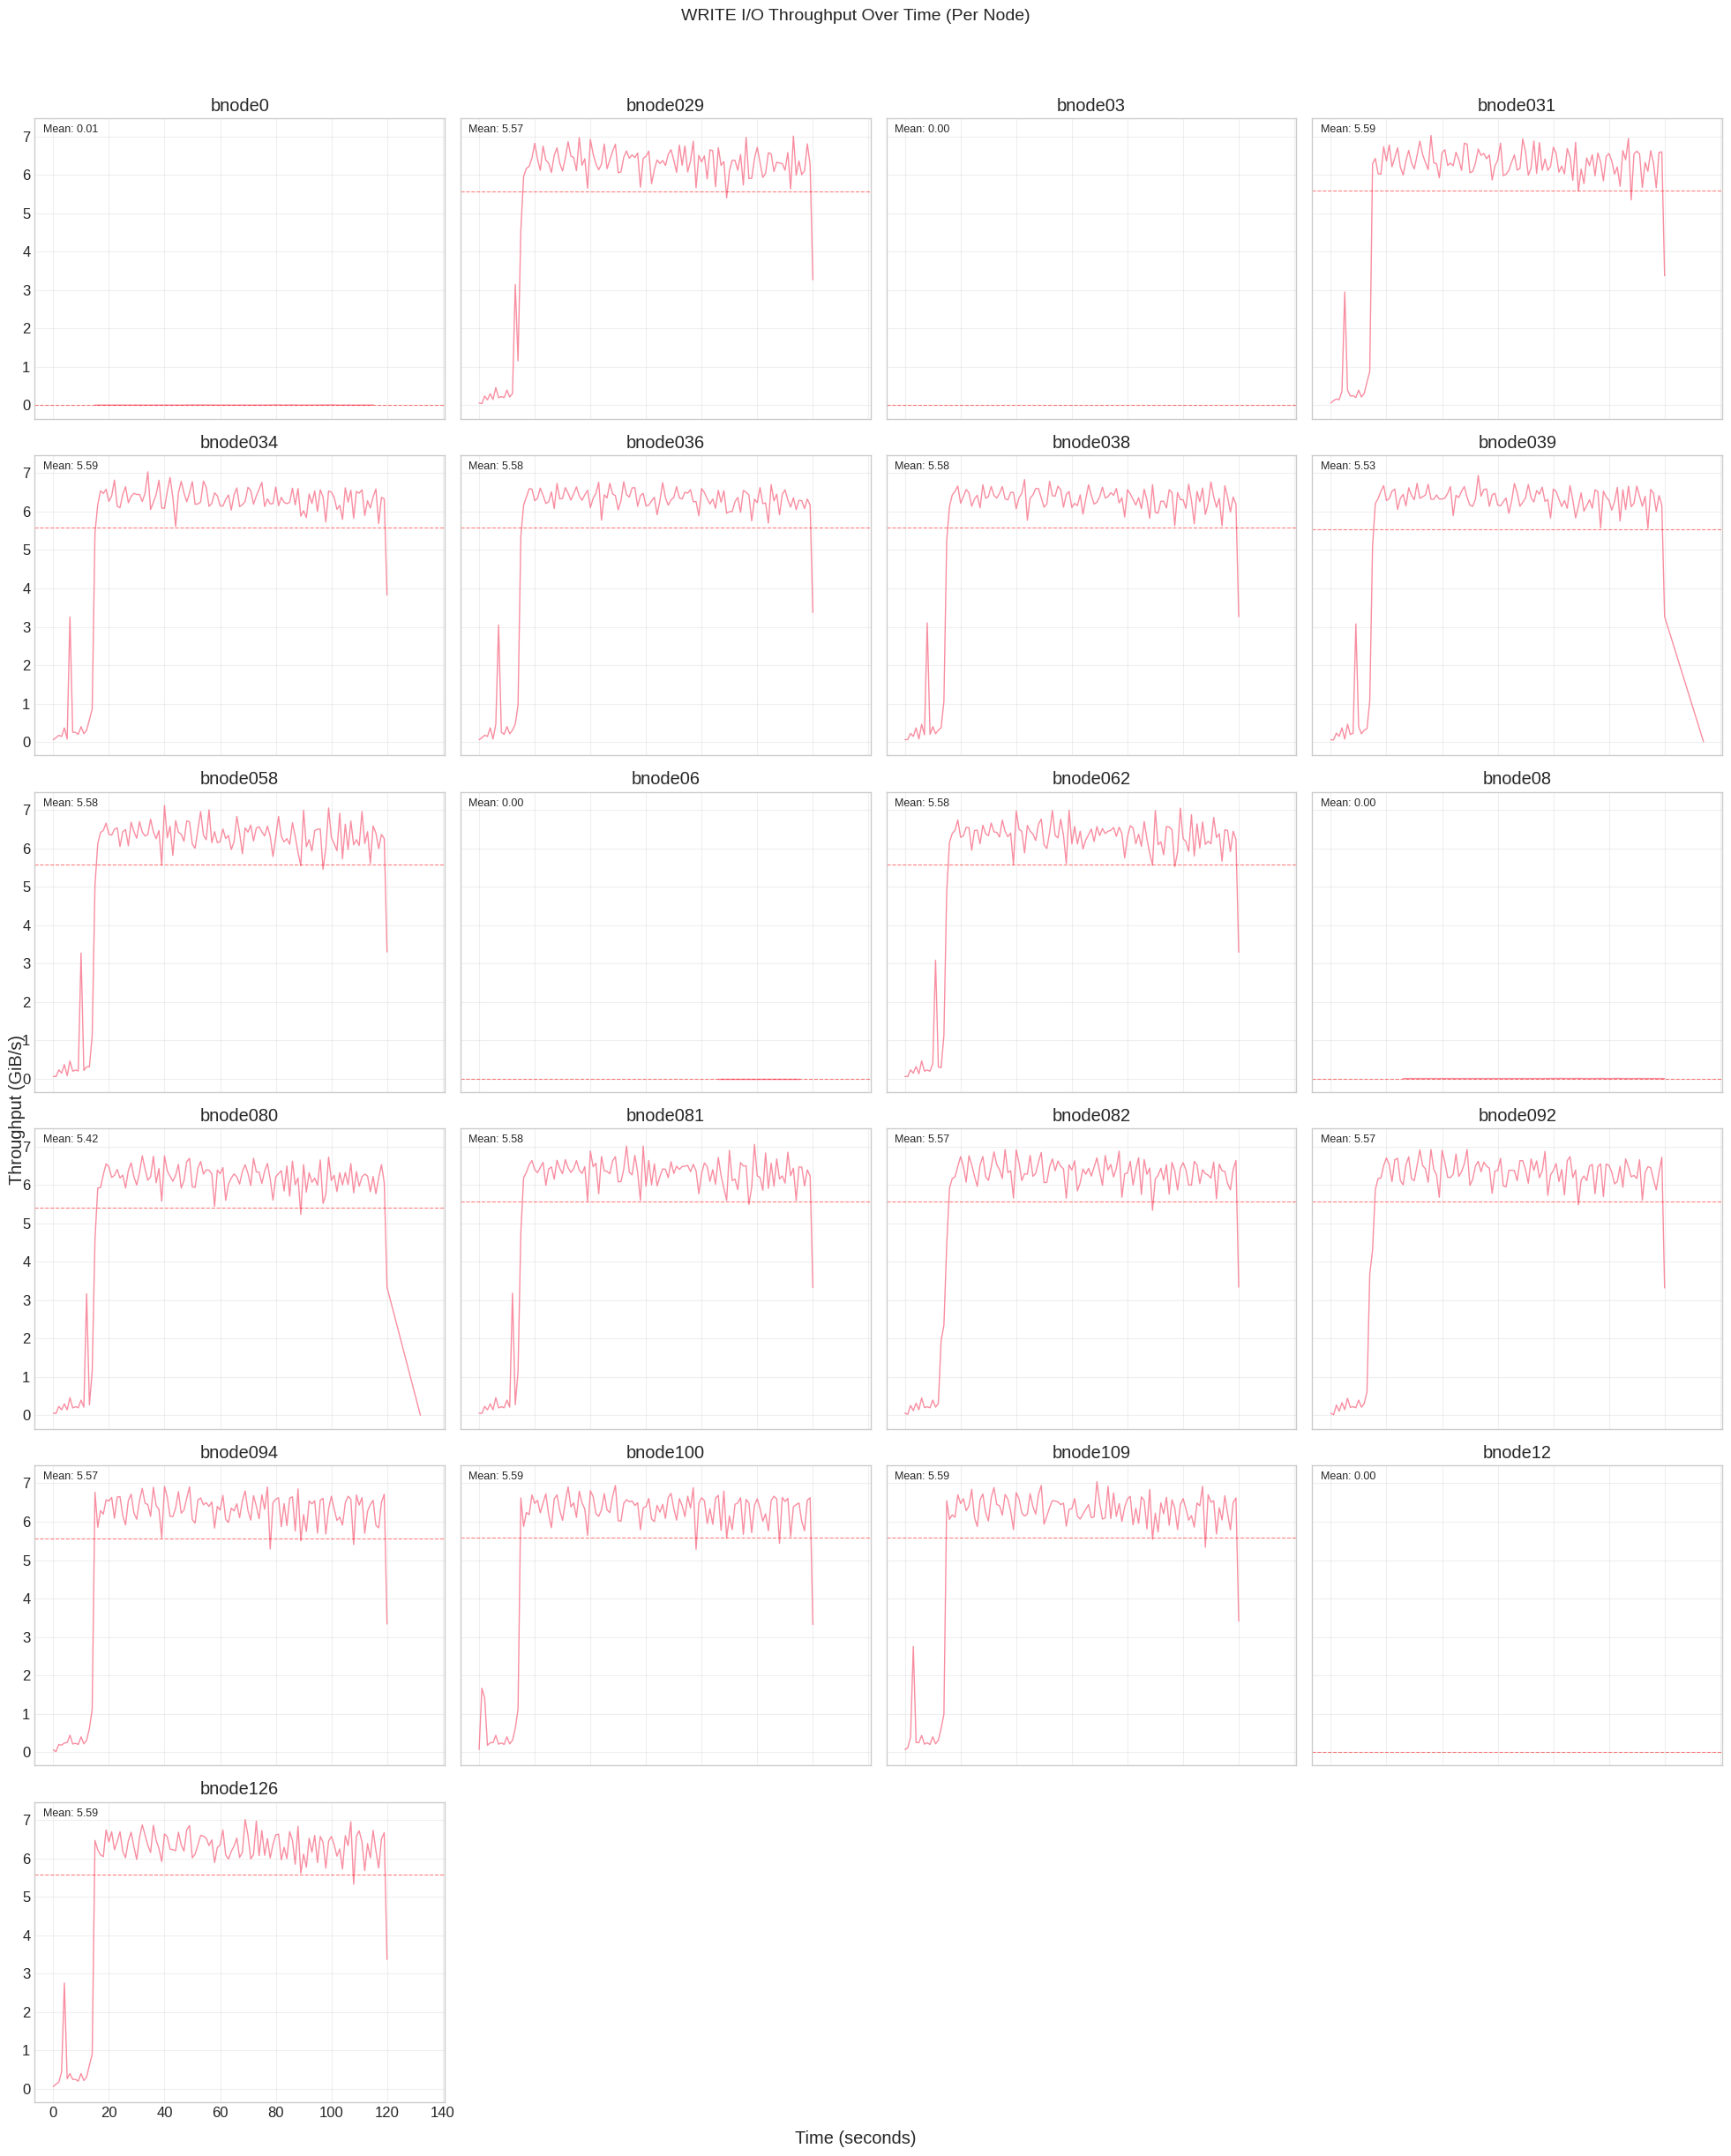

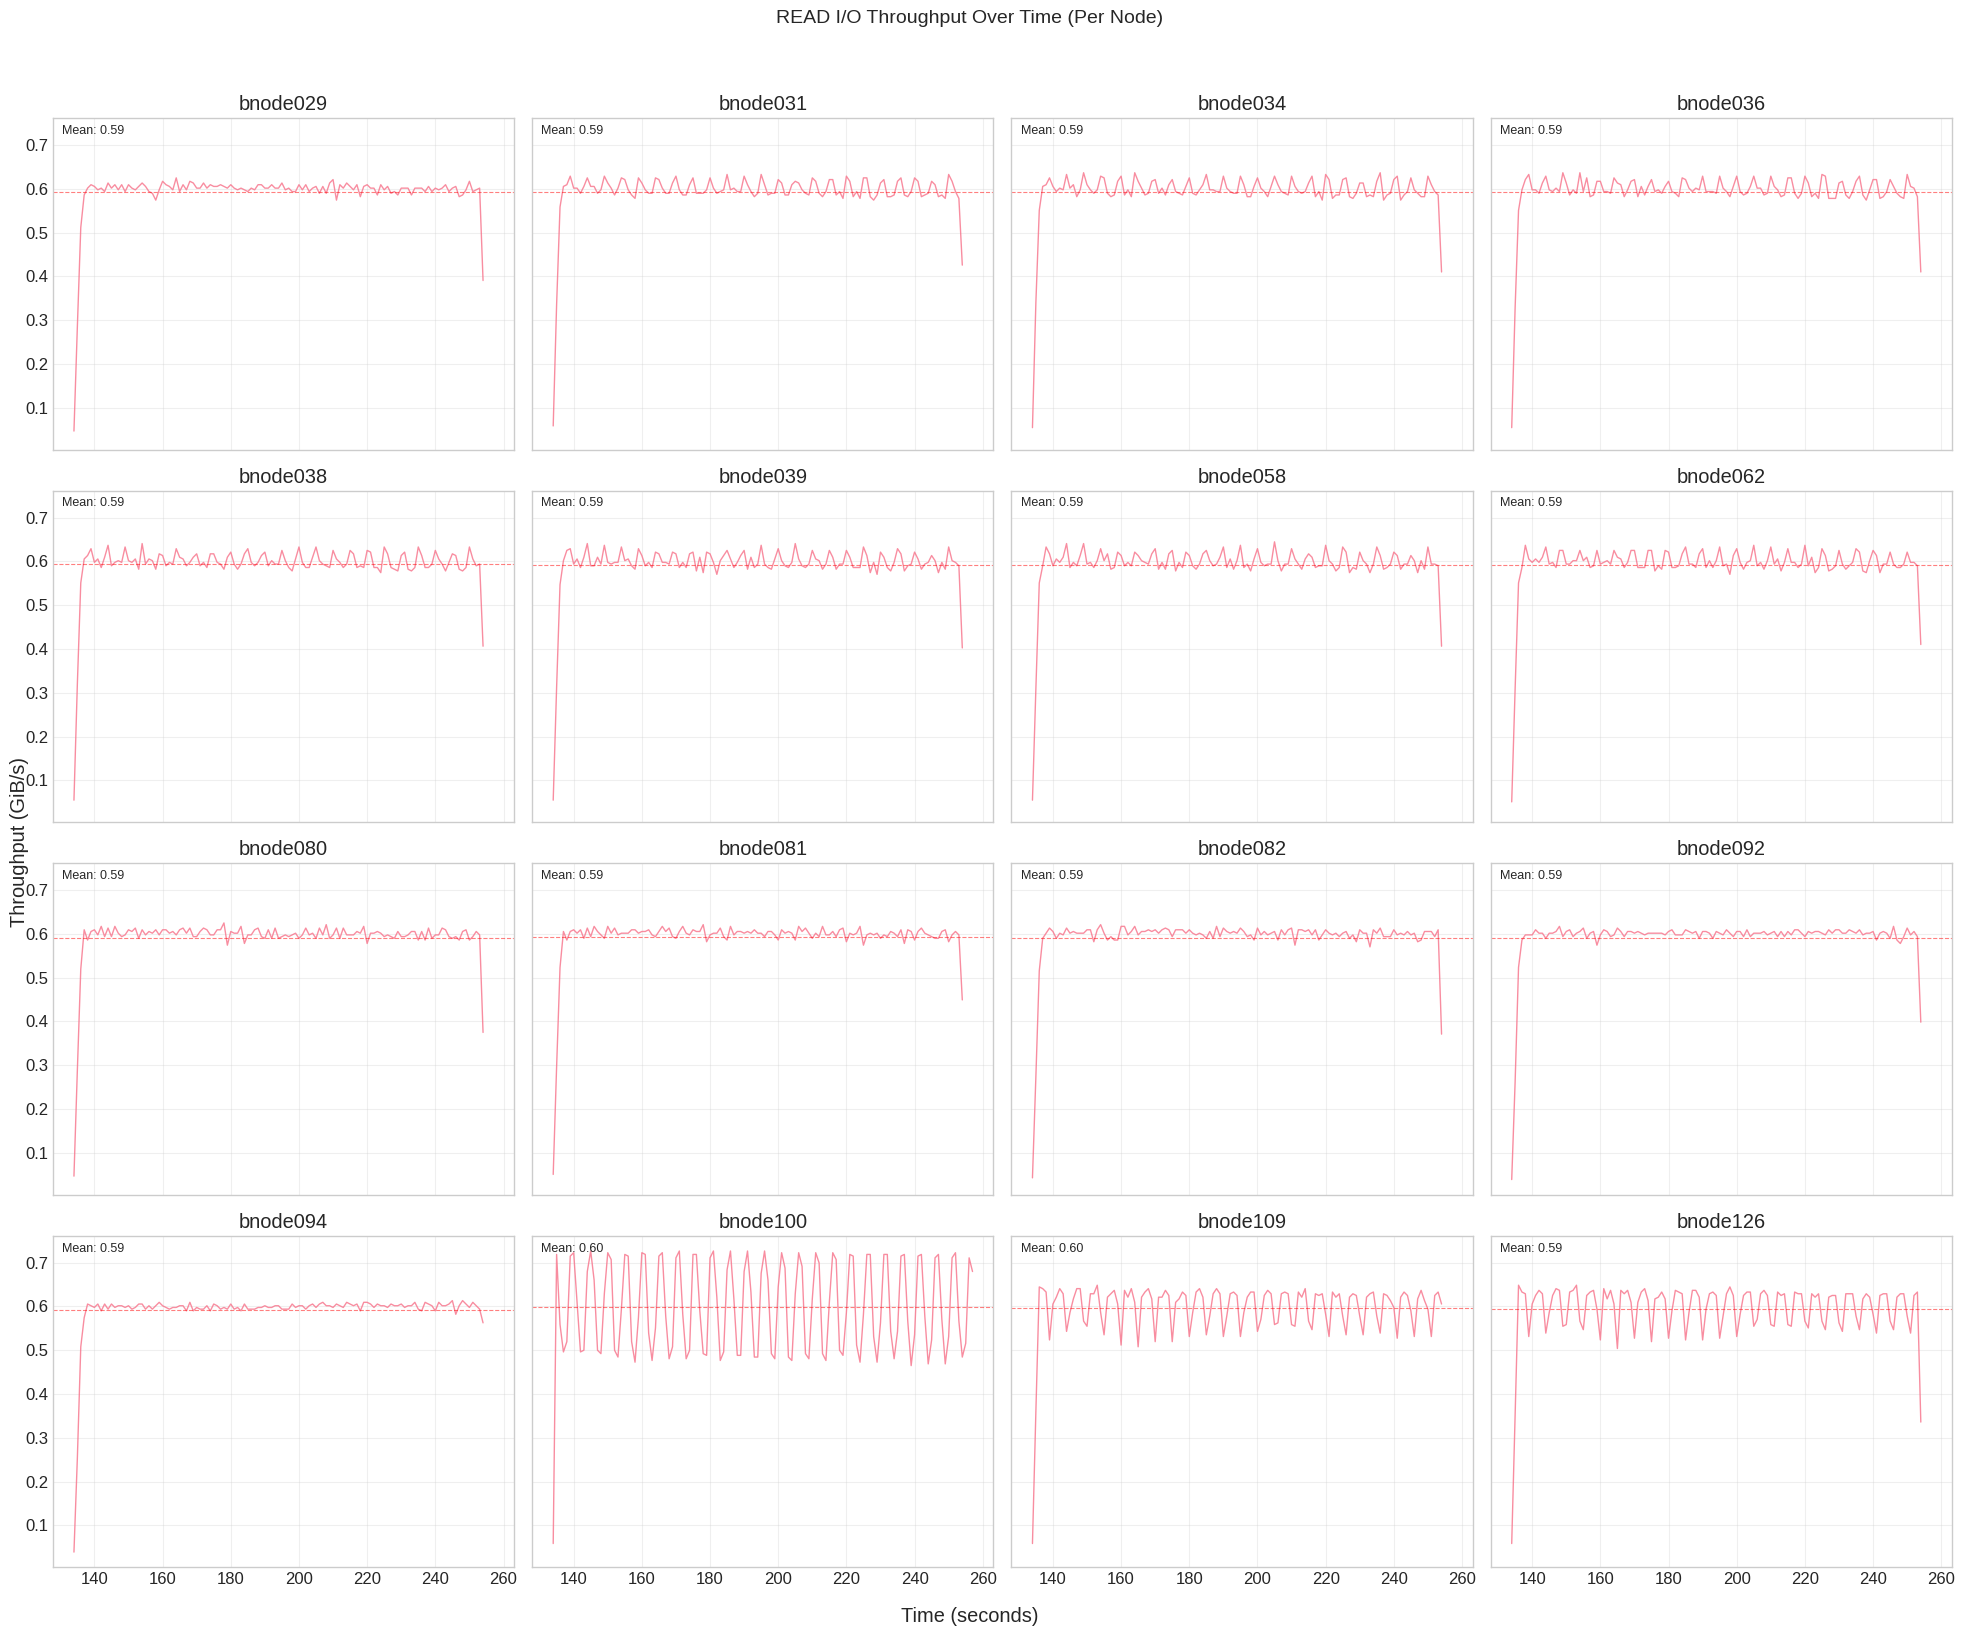

In [14]:
def plot_per_node_throughput(data, op_name, filename):
    if len(data) == 0:
        print(f"No {op_name} data")
        return
    
    # Aggregate by time bucket and node
    node_time_stats = data.groupby(['time_bucket', 'node']).agg({
        'bytes': 'sum',
        'bandwidth_mib_s': 'count'  # count as io_count
    }).reset_index()
    node_time_stats.columns = ['time_bucket', 'node', 'total_bytes', 'io_count']
    node_time_stats['throughput_gib_s'] = node_time_stats['total_bytes'] / (1024**3)
    
    nodes = sorted(data['node'].unique())
    n_nodes = len(nodes)
    
    n_cols = 4
    n_rows = (n_nodes + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for i, node in enumerate(nodes):
        ax = axes[i]
        node_data = node_time_stats[node_time_stats['node'] == node]
        
        ax.plot(node_data['time_bucket'], node_data['throughput_gib_s'], linewidth=1, alpha=0.8)
        ax.set_title(f'{node}')
        ax.grid(True, alpha=0.3)
        
        mean_tp = node_data['throughput_gib_s'].mean()
        ax.axhline(y=mean_tp, color='red', linestyle='--', alpha=0.5, linewidth=0.8)
        ax.text(0.02, 0.98, f'Mean: {mean_tp:.2f}', transform=ax.transAxes, fontsize=9, va='top')
    
    for i in range(n_nodes, len(axes)):
        axes[i].set_visible(False)
    
    fig.suptitle(f'{op_name} I/O Throughput Over Time (Per Node)', fontsize=14, y=1.02)
    fig.supxlabel('Time (seconds)')
    fig.supylabel('Throughput (GiB/s)')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / filename, dpi=150, bbox_inches='tight')
    plt.show()

plot_per_node_throughput(df_write, 'WRITE', 'io_timing_write_throughput_per_node.png')
plot_per_node_throughput(df_read, 'READ', 'io_timing_read_throughput_per_node.png')

## 6. Per-Node I/O Count Over Time

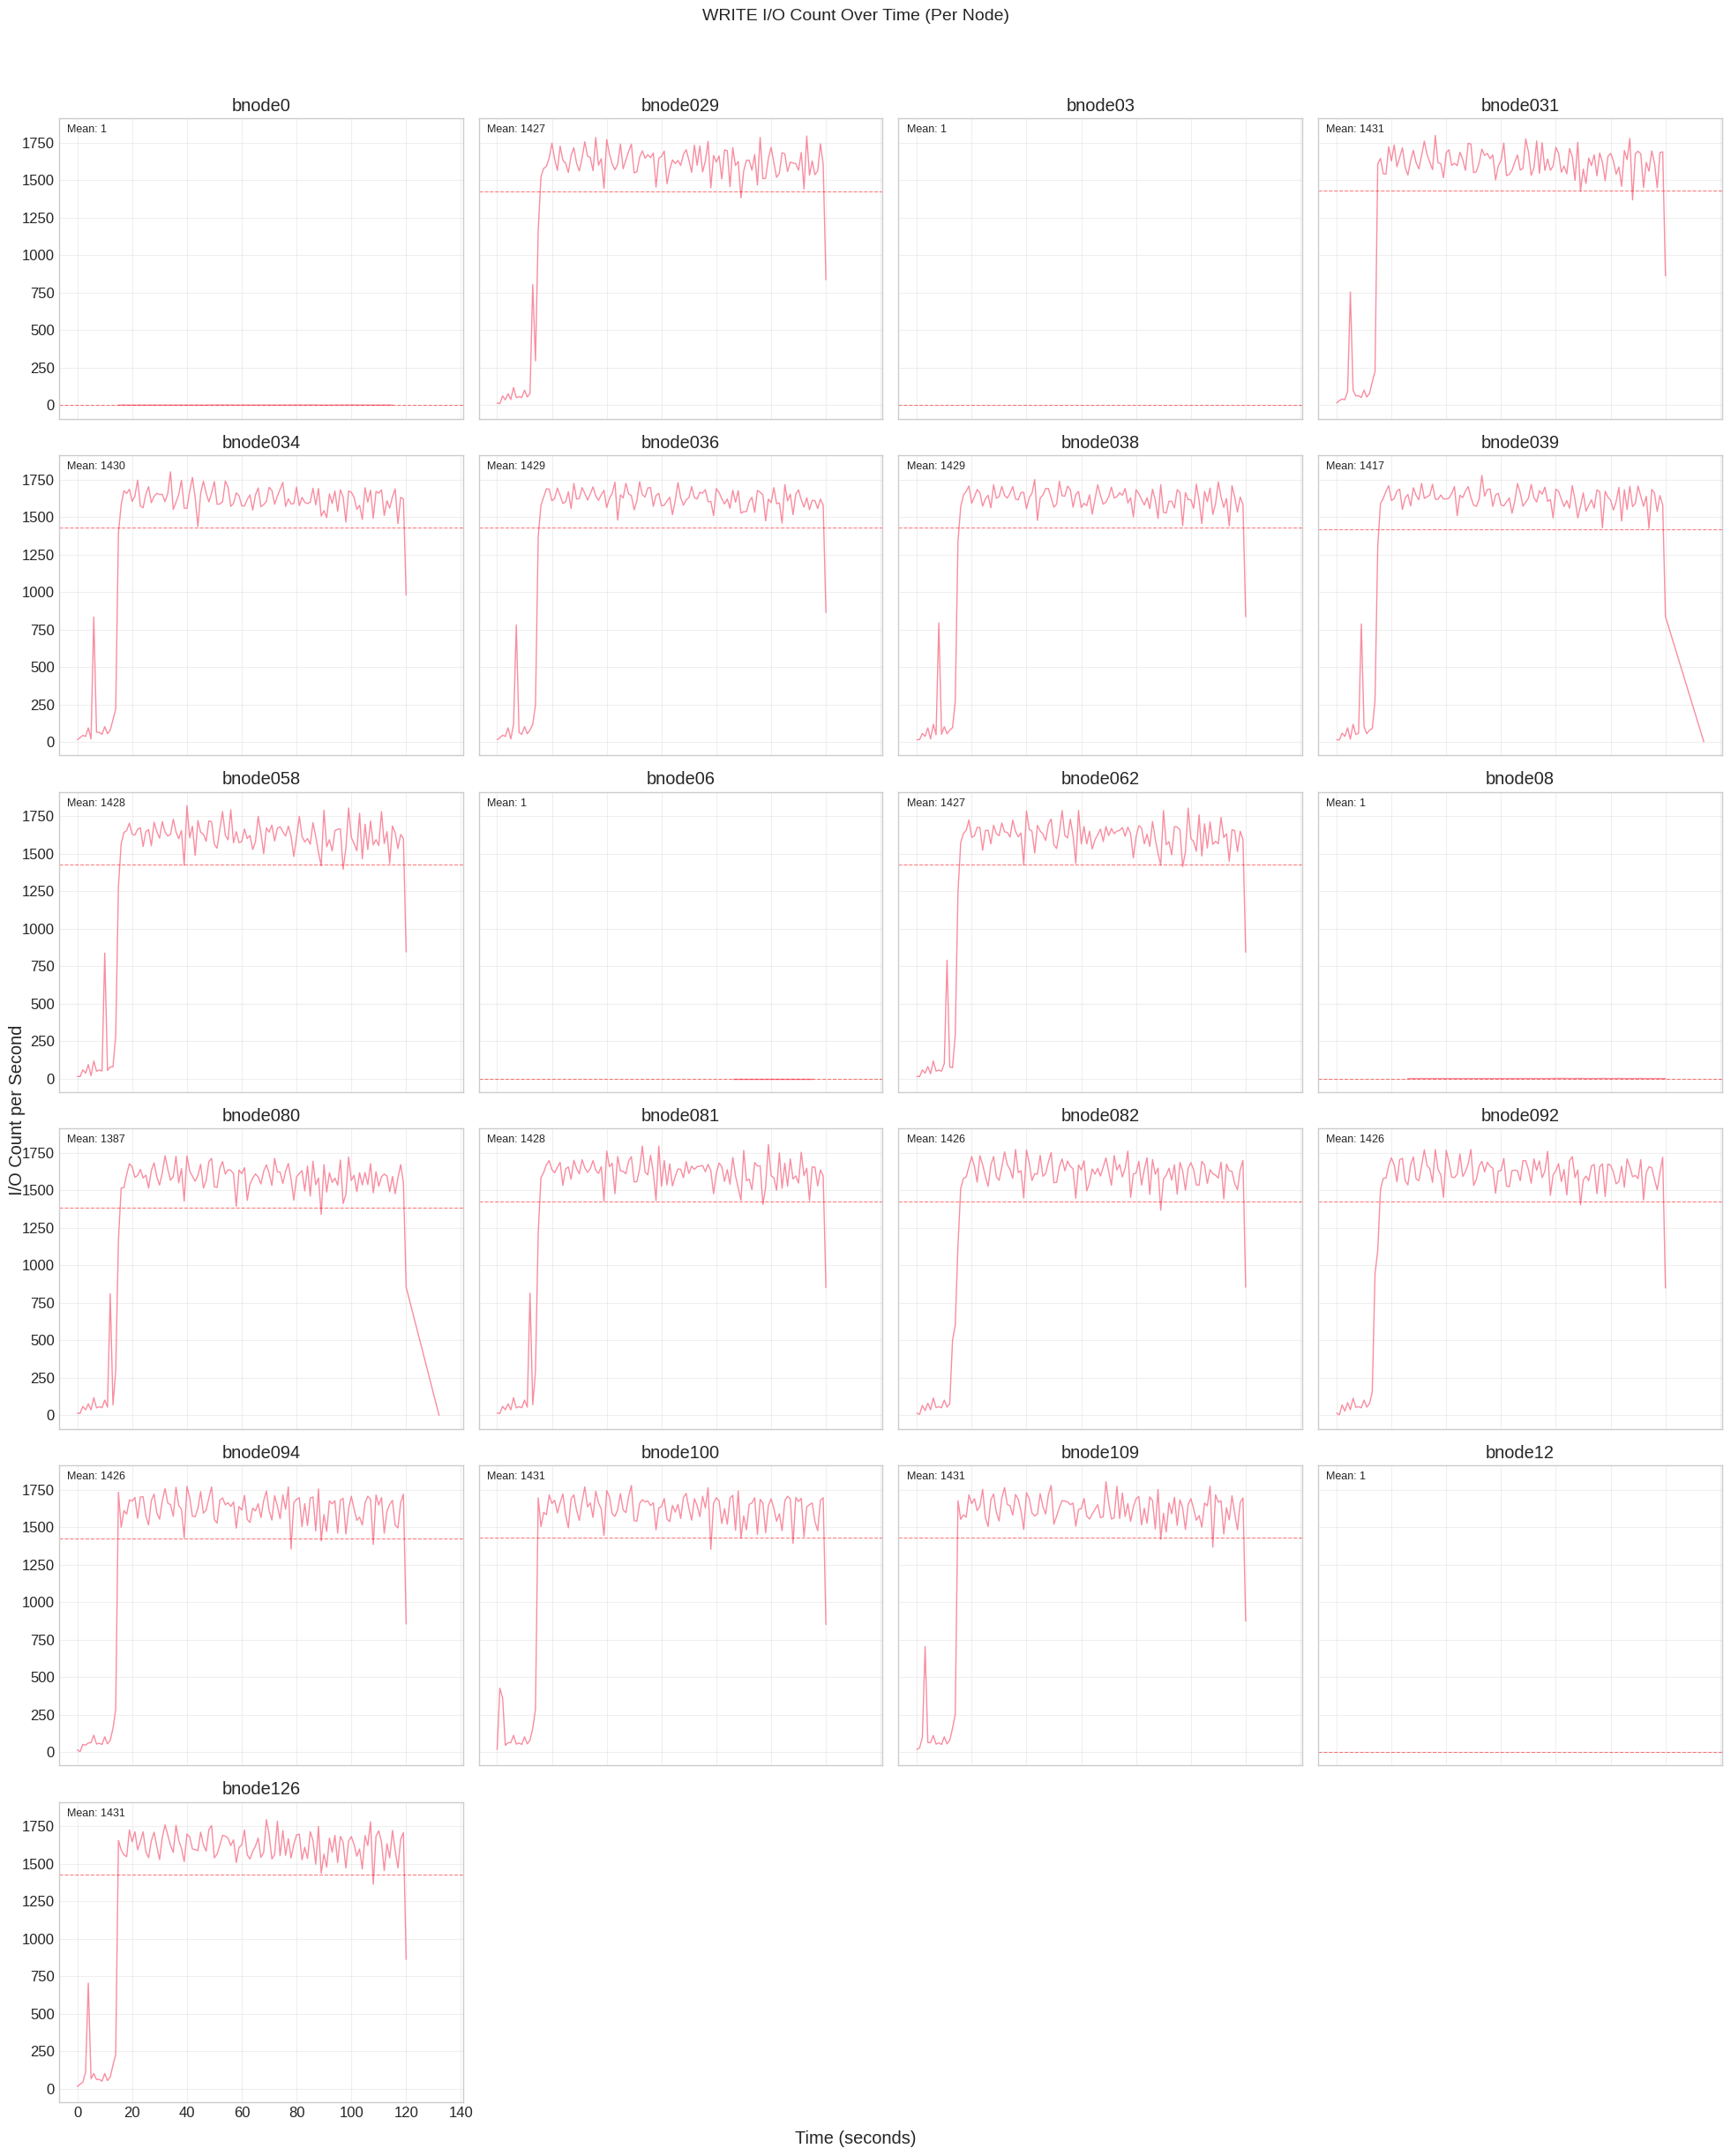

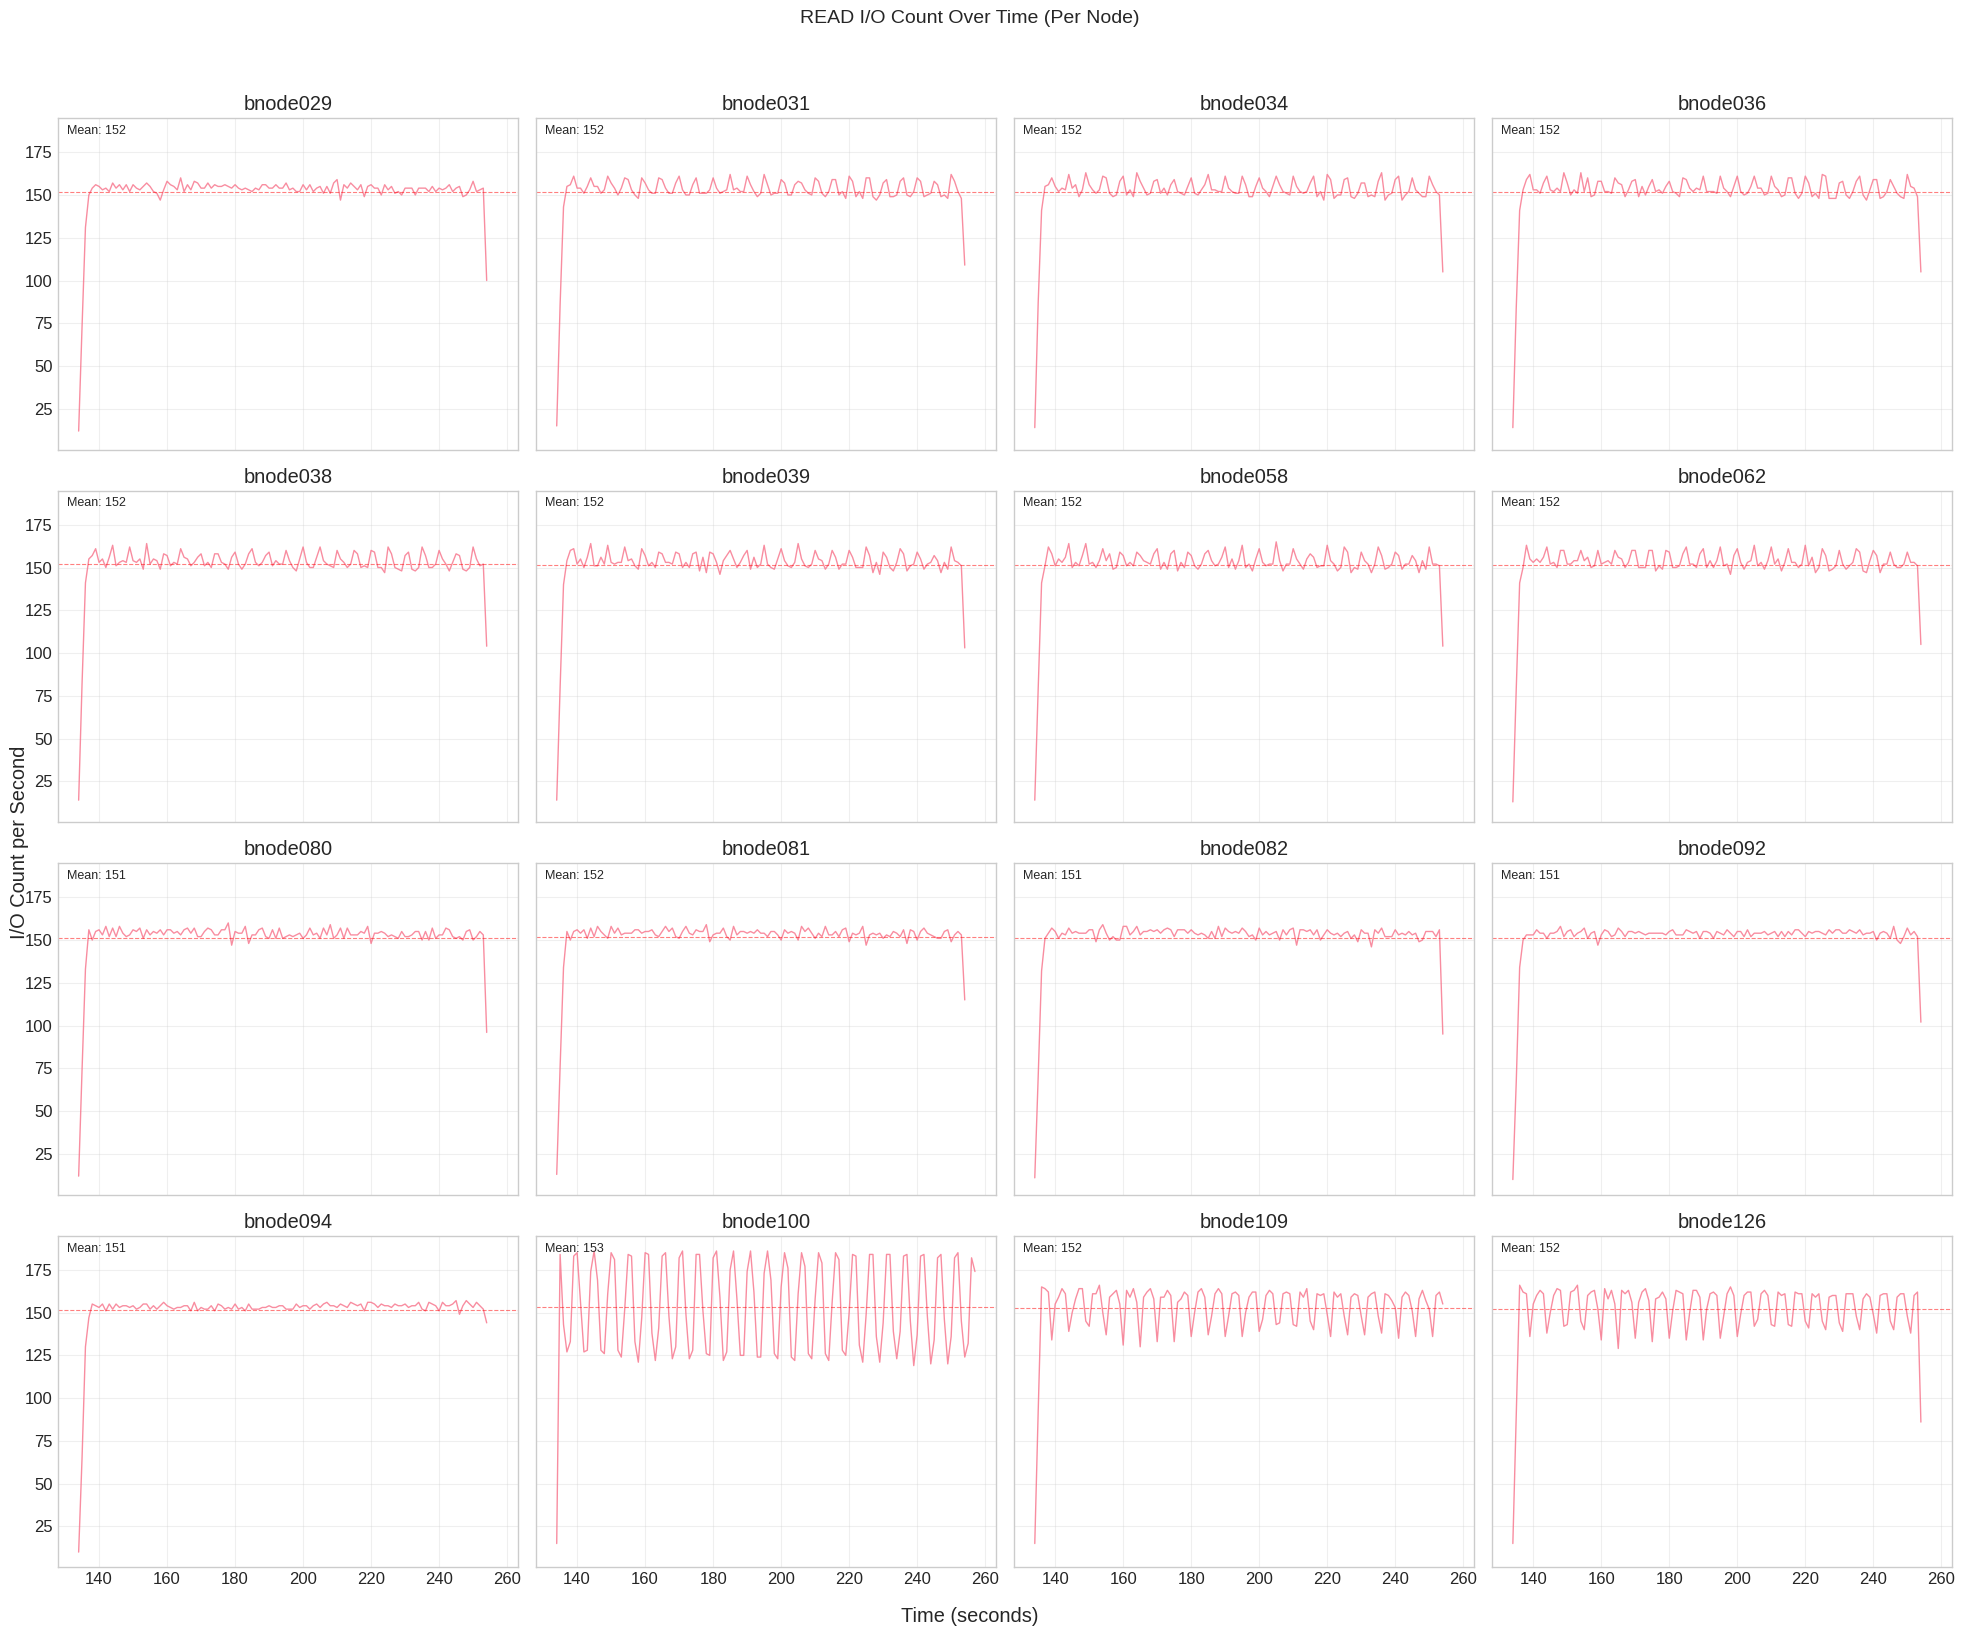

In [15]:
def plot_per_node_io_count(data, op_name, filename):
    if len(data) == 0:
        print(f"No {op_name} data")
        return
    
    # Aggregate by time bucket and node
    node_time_stats = data.groupby(['time_bucket', 'node']).size().reset_index(name='io_count')
    
    nodes = sorted(data['node'].unique())
    n_nodes = len(nodes)
    
    n_cols = 4
    n_rows = (n_nodes + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for i, node in enumerate(nodes):
        ax = axes[i]
        node_data = node_time_stats[node_time_stats['node'] == node]
        
        ax.plot(node_data['time_bucket'], node_data['io_count'], linewidth=1, alpha=0.8)
        ax.set_title(f'{node}')
        ax.grid(True, alpha=0.3)
        
        mean_cnt = node_data['io_count'].mean()
        ax.axhline(y=mean_cnt, color='red', linestyle='--', alpha=0.5, linewidth=0.8)
        ax.text(0.02, 0.98, f'Mean: {mean_cnt:.0f}', transform=ax.transAxes, fontsize=9, va='top')
    
    for i in range(n_nodes, len(axes)):
        axes[i].set_visible(False)
    
    fig.suptitle(f'{op_name} I/O Count Over Time (Per Node)', fontsize=14, y=1.02)
    fig.supxlabel('Time (seconds)')
    fig.supylabel('I/O Count per Second')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / filename, dpi=150, bbox_inches='tight')
    plt.show()

plot_per_node_io_count(df_write, 'WRITE', 'io_timing_write_count_per_node.png')
plot_per_node_io_count(df_read, 'READ', 'io_timing_read_count_per_node.png')

## 7. Per-Node Statistics Summary

In [16]:
# Per-node summary statistics
node_stats = df.groupby(['node', 'op']).agg({
    'bandwidth_mib_s': ['mean', 'median', 'std', 'min', 'max', 'count'],
    'elapsed_ms': ['mean', 'median'],
    'bytes': 'sum'
}).reset_index()
node_stats.columns = ['node', 'op', 'bw_mean', 'bw_median', 'bw_std', 'bw_min', 'bw_max', 'count', 'latency_mean', 'latency_median', 'total_bytes']
node_stats['total_gib'] = node_stats['total_bytes'] / (1024**3)

print("=== WRITE per Node ===")
write_node_stats = node_stats[node_stats['op'] == 'WRITE'].sort_values('node')
print(write_node_stats[['node', 'count', 'total_gib', 'bw_mean', 'bw_median', 'latency_mean']].to_string(index=False))

print("\n=== READ per Node ===")
read_node_stats = node_stats[node_stats['op'] == 'READ'].sort_values('node')
print(read_node_stats[['node', 'count', 'total_gib', 'bw_mean', 'bw_median', 'latency_mean']].to_string(index=False))

=== WRITE per Node ===
    node  count  total_gib    bw_mean  bw_median  latency_mean
  bnode0     25   0.097656 728.682800    362.510     17.062903
bnode029 172641 674.378906 372.583560    358.540     19.877878
 bnode03      1   0.003906  71.460000     71.460     55.972100
bnode031 173130 676.289062 458.586043    362.980     12.092947
bnode034 173088 676.125000 249.766425    170.575     46.484131
bnode036 172903 675.402344 281.399516    181.010     33.410844
bnode038 172868 675.265625 485.341637    365.180     17.020096
bnode039 172838 675.148438 462.072541    363.740     15.325433
bnode058 172812 675.046875 427.740226    363.330     21.947698
 bnode06      2   0.007812 320.960000    320.960     12.625075
bnode062 172695 674.589844 459.171358    362.540     16.340951
 bnode08     31   0.121094 402.067742    359.650     21.038327
bnode080 169180 660.859375 172.820057    119.040     44.233826
bnode081 172741 674.769531 501.801834    365.580     11.652158
bnode082 172545 674.003906 389.9

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (21,) and arg 1 with shape (16,).

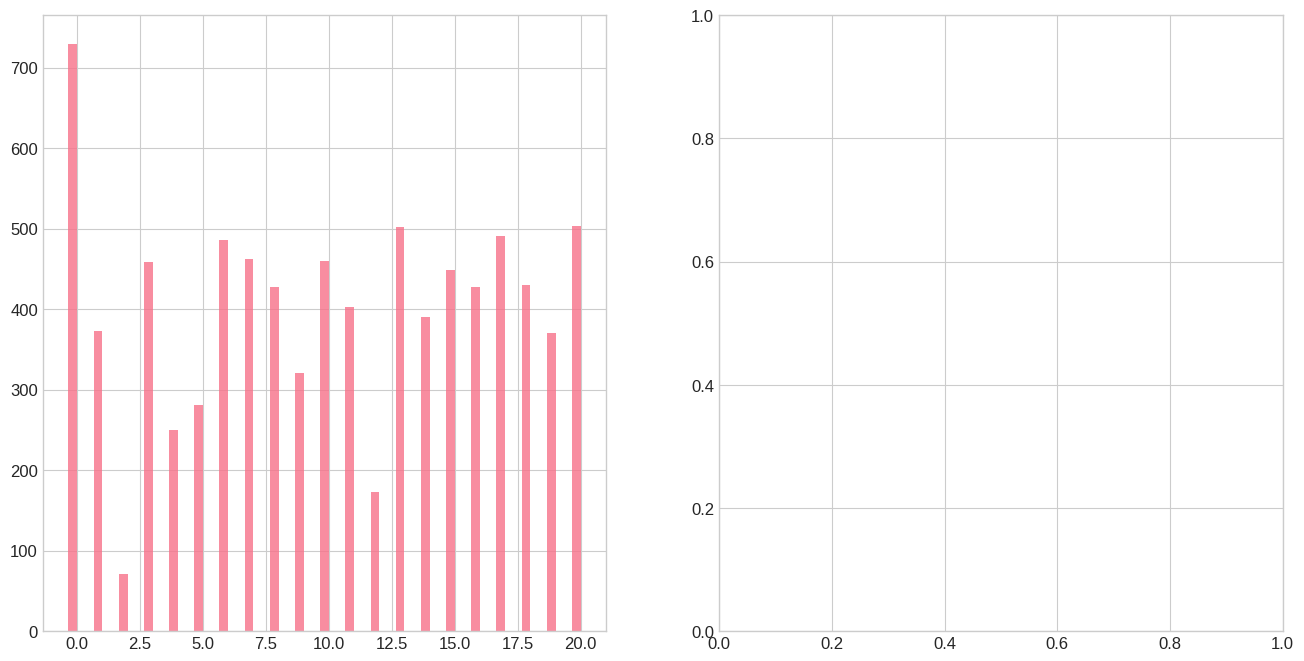

In [17]:
# Bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Mean bandwidth per node
ax = axes[0]
x = np.arange(len(write_node_stats))
width = 0.35

if len(write_node_stats) > 0:
    ax.bar(x - width/2, write_node_stats['bw_mean'], width, label='WRITE', alpha=0.8)
if len(read_node_stats) > 0:
    ax.bar(x + width/2, read_node_stats['bw_mean'], width, label='READ', alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(write_node_stats['node'] if len(write_node_stats) > 0 else read_node_stats['node'], rotation=45, ha='right')
ax.set_xlabel('Node')
ax.set_ylabel('Mean Bandwidth (MiB/s)')
ax.set_title('Mean I/O Bandwidth per Node')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# I/O count per node
ax = axes[1]
if len(write_node_stats) > 0:
    ax.bar(x - width/2, write_node_stats['count'], width, label='WRITE', alpha=0.8)
if len(read_node_stats) > 0:
    ax.bar(x + width/2, read_node_stats['count'], width, label='READ', alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(write_node_stats['node'] if len(write_node_stats) > 0 else read_node_stats['node'], rotation=45, ha='right')
ax.set_xlabel('Node')
ax.set_ylabel('I/O Count')
ax.set_title('Total I/O Count per Node')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'io_timing_per_node_summary.png', dpi=150)
plt.show()

## 8. Comparison: WRITE vs READ (All Nodes)

In [ ]:
print("=" * 80)
print("I/O Timing Comparison: WRITE vs READ")
print("=" * 80)

if len(df_write) > 0:
    print(f"\nWRITE:")
    print(f"  Total I/O count: {len(df_write):,}")
    print(f"  Total bytes: {df_write['bytes'].sum() / (1024**3):.2f} GiB")
    print(f"  Mean bandwidth: {df_write['bandwidth_mib_s'].mean():.2f} MiB/s")
    print(f"  Mean latency: {df_write['elapsed_ms'].mean():.2f} ms")
    print(f"  P50 latency: {df_write['elapsed_ms'].quantile(0.50):.2f} ms")
    print(f"  P99 latency: {df_write['elapsed_ms'].quantile(0.99):.2f} ms")

if len(df_read) > 0:
    print(f"\nREAD:")
    print(f"  Total I/O count: {len(df_read):,}")
    print(f"  Total bytes: {df_read['bytes'].sum() / (1024**3):.2f} GiB")
    print(f"  Mean bandwidth: {df_read['bandwidth_mib_s'].mean():.2f} MiB/s")
    print(f"  Mean latency: {df_read['elapsed_ms'].mean():.2f} ms")
    print(f"  P50 latency: {df_read['elapsed_ms'].quantile(0.50):.2f} ms")
    print(f"  P99 latency: {df_read['elapsed_ms'].quantile(0.99):.2f} ms")

if len(df_write) > 0 and len(df_read) > 0:
    print(f"\nComparison:")
    print(f"  I/O count ratio (WRITE/READ): {len(df_write)/len(df_read):.2f}x")
    print(f"  Bandwidth ratio (WRITE/READ): {df_write['bandwidth_mib_s'].mean()/df_read['bandwidth_mib_s'].mean():.2f}x")
    print(f"  Latency ratio (READ/WRITE): {df_read['elapsed_ms'].mean()/df_write['elapsed_ms'].mean():.2f}x")
    
    if df_read['bandwidth_mib_s'].mean() < df_write['bandwidth_mib_s'].mean() * 0.5:
        print("\n*** WARNING: READ bandwidth is significantly lower than WRITE ***")
        print("This suggests disk I/O is a bottleneck for READ operations.")